# Risk Models Using Tree-based Models

This project builds a machine learning model to predict the 10-year mortality risk of individuals using data from the NHANES I Epidemiologic Follow-up Study. The dataset, curated by the CDC, includes rich baseline information on clinical, nutritional, and behavioral factors. Learn more about the dataset on the [CDC Website](https://wwwn.cdc.gov/nchs/nhanes/nhefs/default.aspx/).

Objective: To explore how early-life health and lifestyle indicators relate to long-term outcomes, particularly mortality, and to evaluate the predictive power of tree-based models in capturing these relationships.

## Table of Contents

1. Import packages
2. The Dataset
    - 2.1 Explore the Dataset
    - 2.2 Check for Duplicates
    - 2.3 Check for Missing Data
    - 2.4 Check for Class Imbalance
3. Decision Trees
4. Random Forests
5. Imputation
    - 5.1 Error Analysis
    - 5.2 Imputation Approaches
        - 5.2.1 Univariate Imputation
        - 5.2.2 Multivariate Imputation
6. Comparing Model Performances
7. Explanations: SHAP

## 1. Import Packages

In [1]:
import shap
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.tree import export_graphviz
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer
from IPython.display import Image
import pydotplus
from util import load_data

SEED = 10
np.random.seed(SEED)

Notes:

- `shap` is a library that explains predictions made by machine learning models.
- `sklearn` is one of the most popular machine learning libraries.
- `numpy` is a fundamental package for scientific computing in Python.
- `pandas` is what we'll use to manipulate our data.
- `seaborn` is a plotting library which has some convenient functions for visualizing missing data.
- `matplotlib` is a plotting library.
- `pydotplus` is used together with `IPython.display.Image` to visualize graph structures such as decision trees.

In [2]:
# import inspect
# print(inspect.getfile(load_data))
# print(inspect.getsource(load_data))

## 2. The Dataset

Let's load the NHANES I epidemiology dataset which contains various features of hospital patients and their outcomes (i.e. whether a patient died within 10 years).

In [3]:
data_path_X = os.path.join(os.getcwd(), "data", "NHANESI_subset_X.csv")
data_path_y = os.path.join(os.getcwd(), "data", "NHANESI_subset_y.csv")
X_dev, X_test, y_dev, y_test = load_data(10, data_path_X , data_path_y)

/Users/francktchafa/PycharmProjects/pythonProject/HelloMulberry/Data AI for Medical Prognosis/Tree-based Models on NHEFS Epidemiologic Study/util.py:32: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'None' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  drop_rows.loc[:, feature_y] = None


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_dev, y_dev, test_size=0.25, stratify=y_dev, random_state=SEED)

### 2.1 Explore the Dataset

Let's get familiar with the data.

In [5]:
print("X_train shape: {}".format(X_train.shape))
X_train.head(10)

X_train shape: (5147, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
8057,40.0,78.0,159.0,1.0,44.8,18.0,4.9,226.0,203.0,1.76,7.9,2.0,NaN,396.0,51.3,6.2,19.205178,60.0
935,36.0,96.0,122.0,2.0,47.8,39.0,4.3,178.0,116.0,1.45,7.8,2.0,NaN,406.0,28.6,6.1,32.880018,30.0
120,41.0,82.0,185.0,1.0,77.7,43.0,4.0,211.0,103.0,1.63,7.5,2.0,NaN,440.0,23.4,10.8,30.586495,36.0
7212,68.0,98.0,372.0,1.0,46.1,9.0,4.6,296.0,108.0,1.69,6.7,2.0,144.0,341.0,31.7,7.4,29.000946,46.0
8105,32.0,74.0,159.0,1.0,48.0,11.0,4.5,201.0,78.0,1.98,7.1,2.0,NaN,361.0,21.6,6.9,24.350924,44.0
1725,49.0,108.0,400.0,1.0,46.1,7.0,4.5,177.0,228.0,1.60,7.2,2.0,NaN,417.0,54.7,8.1,25.508737,62.0
9301,50.0,94.0,275.0,1.0,49.1,5.0,4.3,203.0,121.0,1.71,6.9,2.0,NaN,398.0,30.4,7.0,33.595677,56.0
4647,65.0,92.0,145.0,1.0,42.2,19.0,4.4,197.0,140.0,1.64,7.1,1.0,NaN,358.0,39.1,7.4,22.543780,62.0
5090,66.0,108.0,141.0,1.0,57.4,2.0,4.5,223.0,136.0,1.97,6.6,1.0,204.0,398.0,34.2,9.7,41.386534,96.0
4126,35.0,70.0,292.0,1.0,44.1,14.0,4.6,243.0,125.0,1.68,7.2,2.0,NaN,428.0,29.2,5.0,25.986627,40.0


Our targets `y` will be whether or not the patient died within 10 years.

In [6]:
y_train.head(10)

8057    False
935     False
120     False
7212    False
8105    False
1725    False
9301    False
4647     True
5090    False
4126    False
Name: time, dtype: bool

Let's check a specific case (i.e., a patient's data).

In [7]:
i = 0
index_i = X_train.index[i]
print("Index: {}".format(index_i))
print(X_train.iloc[i,:])
print("\nDied within 10 years? {}".format(y_train.loc[index_i]))

Index: 8057
Age                    40.000000
Diastolic BP           78.000000
Poverty index         159.000000
Race                    1.000000
Red blood cells        44.800000
Sedimentation rate     18.000000
Serum Albumin           4.900000
Serum Cholesterol     226.000000
Serum Iron            203.000000
Serum Magnesium         1.760000
Serum Protein           7.900000
Sex                     2.000000
Systolic BP                  NaN
TIBC                  396.000000
TS                     51.300000
White blood cells       6.200000
BMI                    19.205178
Pulse pressure         60.000000
Name: 8057, dtype: float64

Died within 10 years? False


### 2.2 Check for Duplicates
This is an important steps for the various reasons listed below:
* Skewed analysis: Duplicates distort averages and bias distributions.
* Model overfitting: Repeated samples encourage memorization, reducing generalization.
* Higher compute cost: More rows mean longer training and wasted resources.
* Data integrity risks: Duplicates may signal upstream problems (faulty merges or broken ingestion pipelines).
* Redundant complexity: They clutter the dataset, complicate debugging, and make it harder.

In [8]:
def remove_duplicates(X_, y_):
    """
    Remove duplicate rows from X and corresponding entries in y.
    Preserve the original input format (NumPy array or pandas DataFrame/Series).

    Args:
        X : np.ndarray or pd.DataFrame
            Feature matrix of shape (n_samples, n_features).
        y : np.ndarray or pd.Series
            Target vector of shape (n_samples,).

    Returns:
        X_unique : same type as X_
            Feature matrix with duplicates removed.
        y_unique : same type as y_
            Target vector aligned with X_unique.
    """

    # Convert to DataFrame for uniform duplicate detection
    X_df = pd.DataFrame(X_)
    y_series = pd.Series(y_)

    # Identify unique rows
    unique_mask = ~X_df.duplicated()  # Returns True for unique rows
    #  Note: ~ is a boolean bouncer that flips the list of duplicates into a list of keepers.

    # Filter both X and y
    X_unique_df = X_df[unique_mask]
    y_unique_series = y_series[unique_mask]

    # Return in original format
    X_unique = X_unique_df.to_numpy() if isinstance(X_, np.ndarray) else X_unique_df
    y_unique = y_unique_series.to_numpy() if isinstance(y_, np.ndarray) else y_unique_series

    return X_unique, y_unique

In [9]:
# Check for duplicates
datasets = {"train": (X_train, y_train), "val": (X_val, y_val), "test": (X_test, y_test)}
X_clean_all, y_clean_all = {}, {}

for name, (X, y) in datasets.items():
    X_clean, y_clean = remove_duplicates(X, y)
    X_clean_all[name] = X_clean
    y_clean_all[name] = y_clean

    num_duplicates = len(y) - len(y_clean)
    msg = f"Removed {num_duplicates} duplicate samples" if num_duplicates > 0 else "No duplicates found"
    print(f"{msg} in {name} dataset.")


No duplicates found in train dataset.
No duplicates found in val dataset.
No duplicates found in test dataset.


### 2.3 Check for Missing Data
Missing data is common in medical data and can result from a variety of reasons such as faulty instruments, patient unwillingness to provide information, or data entry errors. Let’s check for any missing values.

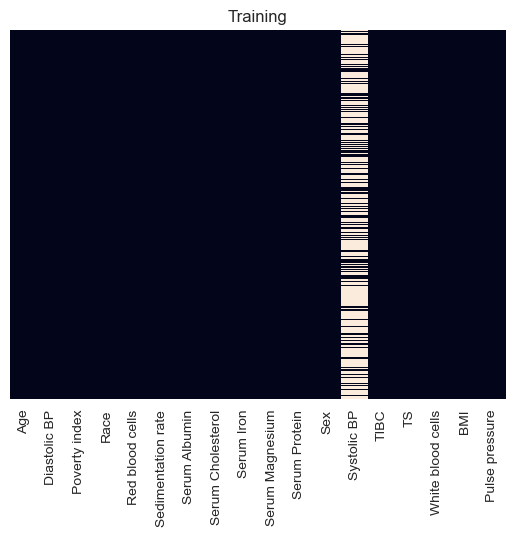

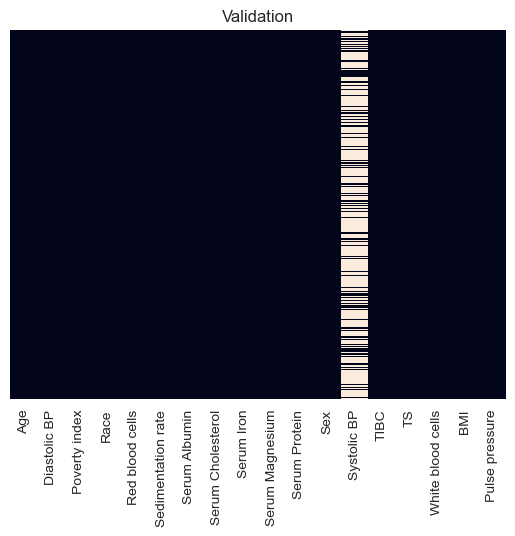

In [10]:
sns.heatmap(X_train.isnull(), cbar=False, yticklabels=False)
# plt.xticks(rotation=70)
plt.title("Training")
plt.show()

sns.heatmap(X_val.isnull(), cbar=False, yticklabels=False)
plt.title("Validation")
plt.show()

From this plot, we can see that many values are missing for systolic blood pressure (`Systolic BP`).

We can do complete case analysis or imputation. We'll explore both opitons


In [11]:
X_train.isnull().mean() #.sort_values(ascending=False)

Age                   0.000000
Diastolic BP          0.000000
Poverty index         0.000000
Race                  0.000000
Red blood cells       0.000000
Sedimentation rate    0.000000
Serum Albumin         0.000000
Serum Cholesterol     0.000000
Serum Iron            0.000000
Serum Magnesium       0.000000
Serum Protein         0.000000
Sex                   0.000000
Systolic BP           0.703517
TIBC                  0.000000
TS                    0.000000
White blood cells     0.000000
BMI                   0.000000
Pulse pressure        0.000000
dtype: float64

### Compute Fraction of Missing Rows

Let's compute the fraction of cases with missing data. This will help us decide how to handle the missing data in the future.

In [12]:
def fraction_rows_missing(df):
    '''
    Return percent of rows with any missing
    data in the dataframe. 
    
    Input:
        df (dataframe): a pandas dataframe with potentially missing data
    Output:
        frac_missing (float): fraction of rows with missing data
    '''

    return df.isnull().any(axis=1).mean()


In [13]:
print(f"Fraction of rows with missing data.\n\tTrain dataset: {fraction_rows_missing(X_train):.3f}")
print(f"\tValidation dataset: {fraction_rows_missing(X_val):.3f}")
print(f"\tTest dataset: {fraction_rows_missing(X_test):.3f}")

Fraction of rows with missing data.
	Train dataset: 0.704
	Validation dataset: 0.689
	Test dataset: 0.000


We see that our train and validation sets have missing values, but luckily our test set has complete cases.

As a first step, let's begin with a **complete case analysis**, dropping all of the rows with any missing data.

In [14]:
X_train_dropped = X_train.dropna(axis='rows')
y_train_dropped = y_train.loc[X_train_dropped.index]

X_val_dropped = X_val.dropna(axis='rows')
y_val_dropped = y_val.loc[X_val_dropped.index]

print("New X train shape {} and X validation shape {}".format(X_train_dropped.shape, X_val_dropped.shape))
X_train_dropped.head()

New X train shape (1526, 18) and X validation shape (533, 18)


,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure
7212,68.0,98.0,372.0,1.0,46.1,9.0,4.6,296.0,108.0,1.69,6.7,2.0,144.0,341.0,31.7,7.4,29.000946,46.0
5090,66.0,108.0,141.0,1.0,57.4,2.0,4.5,223.0,136.0,1.97,6.6,1.0,204.0,398.0,34.2,9.7,41.386534,96.0
7320,66.0,108.0,14.0,2.0,40.9,9.0,4.0,241.0,83.0,1.53,6.9,2.0,152.0,344.0,24.1,4.3,36.506659,44.0
6789,66.0,72.0,282.0,1.0,51.4,10.0,4.0,180.0,63.0,1.79,7.1,1.0,140.0,357.0,17.6,7.1,21.440541,68.0
4316,68.0,84.0,494.0,1.0,77.7,27.0,4.2,223.0,117.0,1.58,7.1,1.0,130.0,292.0,40.1,9.0,27.612715,46.0


### 2.4 Check for Class Imbalance

In [15]:
from collections import Counter

# Check the number of sample per class
# print(np.bincount(y_train.to_numpy().astype(int)))
class_count_dict = dict(sorted(dict(Counter(y_train)).items()))
class_count_dict

{False: 4188, True: 959}

With class counts of 4,188 and 959, the dataset is clearly imbalanced. The model must compensate to avoid bias toward the dominant class.

Omitting class_weight during training would allow the imbalance to skew the decision boundary, reducing sensitivity to the minority class and undermining the model’s clinical utility.

In [16]:
def compute_class_weights(y_):
    '''
    Compute class weights based on class counts.
    Args:
        y_ (np.ndarray or pd.Series): Target vector of shape (n_samples,).

    Returns:
        class_weights (dict): Dictionary mapping class names to weights.
    '''

    from sklearn.utils.class_weight import compute_class_weight

    classes = np.unique(y_).tolist()
    class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_), y=y_.to_numpy())
    class_weights_dict = dict(zip(classes, np.round(class_weights, 2)))

    return class_weights_dict

In [17]:
class_weights_dict_dropped = compute_class_weights(y_train_dropped)
class_weights_dict_dropped

{False: np.float64(0.77), True: np.float64(1.41)}

In [18]:
class_weights_dict_orig = compute_class_weights(y_train)
class_weights_dict_orig

{False: np.float64(0.61), True: np.float64(2.68)}

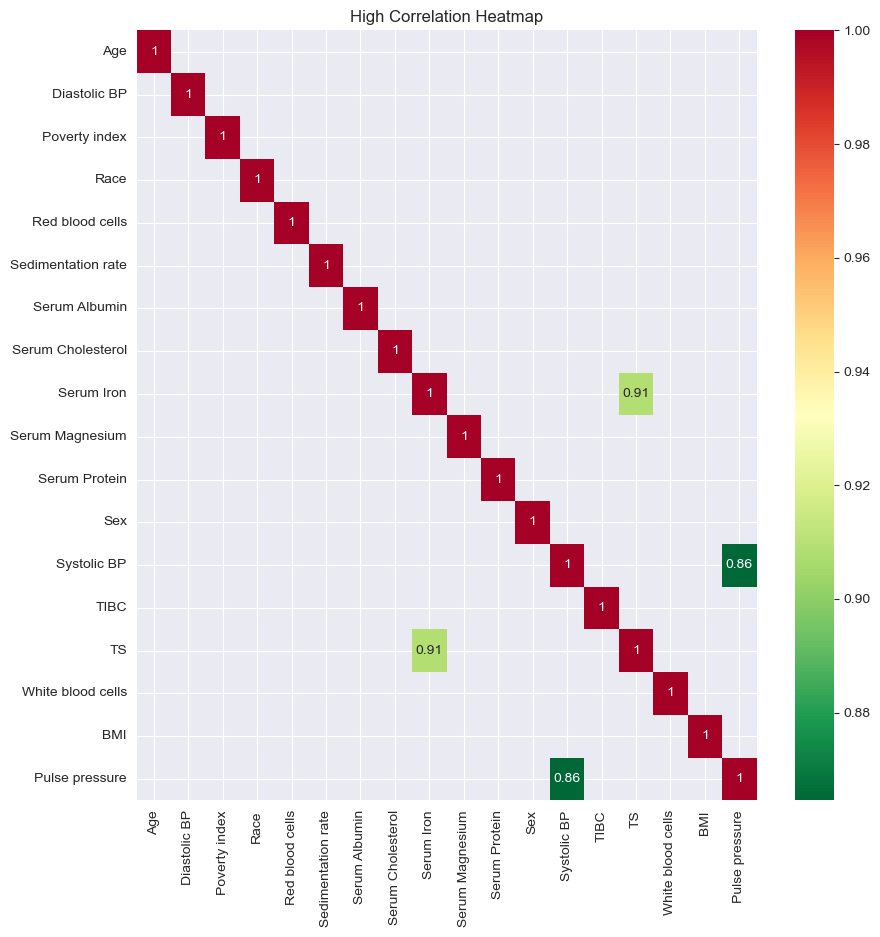

In [19]:
# Compute correlation matrix
corr = X_train_dropped.corr()

# Mask for high correlation
mask = np.abs(corr) >= 0.8
plt.figure(figsize=(10, 10))
sns.heatmap(corr, cmap='RdYlGn_r', mask=~mask, annot=True)
plt.title("High Correlation Heatmap")
plt.show()

* **Serum Iron and TS (Transferrin Saturation) at 0.91**: A textbook case of collinearity—TS is derived from Serum Iron and TIBC, so this correlation is expected. In linear models, we likely don’t need both.
* **Systolic BP and Pulse Pressure at 0.86**: This structural correlation stems from Pulse Pressure being derived from Systolic and Diastolic BP. Including both may dilute interpretability unless modeling interactions.
* **Feature pruning**: Highly correlated features can be dropped or clustered to reduce redundancy. In linear models, this helps avoid instability and improves interpretability. Typically drop one or orthogonalize them.
* **Interaction targeting**: Strong correlations can guide where to test for nonlinear interactions—e.g., Serum Iron × Age or Pulse Pressure × BMI may uncover risk patterns not visible in individual features.
    * **Serum Iron × Age**: Iron metabolism shifts with age; high iron might be benign in youth but risky in seniors.
    * **TS × Pulse Pressure**: Exploratory, but may reveal systemic risk if vascular stress affects iron transport.
    * **Tree-based models** (e.g., XGBoost, Random Forests) can capture these interactions naturally.
    * **Linear models** require explicit engineering.
* **Model selection**: For tree-based models, one might retain correlated features to enhance interpretability via SHAP. Again, for linear models, pruning or orthogonalization is often preferred.

## 3. Decision Trees

Let's explore our first classifier using decision trees from the sklearn library.

In [20]:
dt = DecisionTreeClassifier(max_depth=None, class_weight=class_weights_dict_dropped, random_state=SEED)
dt.fit(X_train_dropped, y_train_dropped)

DecisionTreeClassifier(class_weight={False: np.float64(0.77),
                                     True: np.float64(1.41)},
                       random_state=10)

Let's evaluate our model using the C-Index.
> The C-Index measures how well a model ranks risk by evaluating all patient pairs with different outcomes.
> It checks how often the model assigns a higher risk score to the patient who actually died.
>
> In binary classification, where scores are 0 or 1, _permissible pairs_ are those with differing outcomes, _concordant pairs_ are those where the deceased patient has a higher predicted risk, and _ties_ occur when both patients receive the same score.
>
> The C-Index is the proportion of concordant pairs among all permissible pairs, adjusted for ties. More formally, the C-Index is equal to:
>
> $$\text{C-Index} = \frac{\#\text{concordant pairs} + 0.5\times \#\text{ties}}{\#\text{permissible pairs}}$$

In [21]:
from lifelines.utils import concordance_index

# Function for scoring (i.e., Concordance Index)
def c_index_score(y_true, y_pred):
    return concordance_index(y_true, y_pred)

In [22]:
y_train_preds = dt.predict_proba(X_train_dropped)[:, 1]
print(f"Train C-Index: {c_index_score(y_train_dropped.values, y_train_preds)}")

y_val_preds = dt.predict_proba(X_val_dropped)[:, 1]
print(f"Val C-Index: {c_index_score(y_val_dropped.values, y_val_preds)}")

Train C-Index: 1.0
Val C-Index: 0.5729436813626613


Unfortunately, there's overfitting: the decision tree fits the training data perfectly that it doesn't generalize well on the validation set.

To handle this, let's tune some of the hyperparameters of our tree.

### Decision Tree Hyperparameter Tuning

In [23]:
models = {
    'Decision Tree': {
        'model': DecisionTreeClassifier(class_weight=class_weights_dict_dropped, random_state=SEED),
        'params': {'min_samples_split': [2, 10, 30, 50, 100, 150, 200],
                   'max_depth': [2, 3, 4, 5, 10, None]
                   }
    }
}

In [24]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import make_scorer

custom_scorer = make_scorer(c_index_score, greater_is_better=True)
model_scores, best_model_info = [], {}


model_name, mp = list(models.items())[0]
clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=custom_scorer)
# clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, scoring=custom_scorer)

clf.fit(X_train_dropped, y_train_dropped)

GridSearchCV(cv=5,
             estimator=DecisionTreeClassifier(class_weight={False: np.float64(0.77),
                                                            True: np.float64(1.41)},
                                              random_state=10),
             param_grid={'max_depth': [2, 3, 4, 5, 10, None],
                         'min_samples_split': [2, 10, 30, 50, 100, 150, 200]},
             scoring=make_scorer(c_index_score, response_method='predict'))

In [25]:
# Function to evaluate the model
def evaluate_classifier(my_clf, Xtrain_, ytrain_, Xcv_, ycv_, Xtest_, ytest_, scorer):
    '''
    Use the provided classifier and scorer to evaluate the model on the various datasets
    Return the scores for each dataset.
    '''

    model = my_clf

    # Predict probabilities
    y_train_proba = model.predict_proba(Xtrain_)[:, 1]
    y_val_proba = model.predict_proba(Xcv_)[:, 1]
    y_test_proba = model.predict_proba(Xtest_)[:, 1]

    # Compute scores using provided scorer
    score_train = scorer(ytrain_, y_train_proba)
    score_val = scorer(ycv_, y_val_proba)
    score_test = scorer(ytest_, y_test_proba)

    return score_train, score_val, score_test

In [26]:
dt_ci_train, dt_ci_val, dt_ci_test = evaluate_classifier(
    my_clf = clf.best_estimator_,
    Xtrain_=X_train_dropped,
    ytrain_=y_train_dropped.values,
    Xcv_=X_val_dropped,
    ycv_=y_val_dropped.values,
    Xtest_=X_test,
    ytest_=y_test.values,
    scorer=c_index_score
)

print(f"Train C-index: {dt_ci_train:.4f}")
print(f"Val C-index: {dt_ci_val:.4f}")
print(f"Test C-index: {dt_ci_test:.4f}")

Train C-index: 0.7292
Val C-index: 0.6370
Test C-index: 0.6456


**Overfitting, underfitting, and the bias-variance tradeoff**

The goal is to find the best hyperparameter set that strikes the right balance between overfitting and underfitting—this is the essence of the bias-variance tradeoff.

Focusing on tree depth (i.e., `max_depth`)
* A shallow model may underfit, failing to capture meaningful patterns and yielding low predictive performance.
* A deep model may overfit, memorizing noise and performing poorly on unseen data.
* The bias-variance tradeoff is about navigating this tension: choosing a model complex enough to learn from the data, but simple enough to generalize reliably.
* In practice, this often means selecting a depth that offers strong validation performance without excessive training accuracy, signaling that the model is learning patterns—not just memorizing them.

No matter how we choose hyperparameters, a single decision tree is prone to overfitting. To solve this problem, let's try **random forests**, which combine predictions from many different trees to create a robust classifier.

But first, let's visualize the current tree and store it performance for comparison later and let's  .

In [27]:
# Store performance and fitted model
model_scores.append({
    'model': model_name,
    'CI_train': dt_ci_train,
    'CI_val': dt_ci_val,
    'CI_test': dt_ci_test
})

best_model_info[model_name]={
    'model':  clf.best_estimator_,  # Fitted with best parameters
    'best_params': clf.best_params_,
    'CI_train': dt_ci_train,
    'CI_val': dt_ci_val,
    'CI_test': dt_ci_test
}

In [28]:
from six import StringIO

dot_data = StringIO()
export_graphviz(clf.best_estimator_, feature_names=X_train_dropped.columns, out_file=dot_data,
                filled=True, rounded=True, proportion=True, special_characters=True,
                impurity=False, class_names=['neg', 'pos'], precision=2)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())

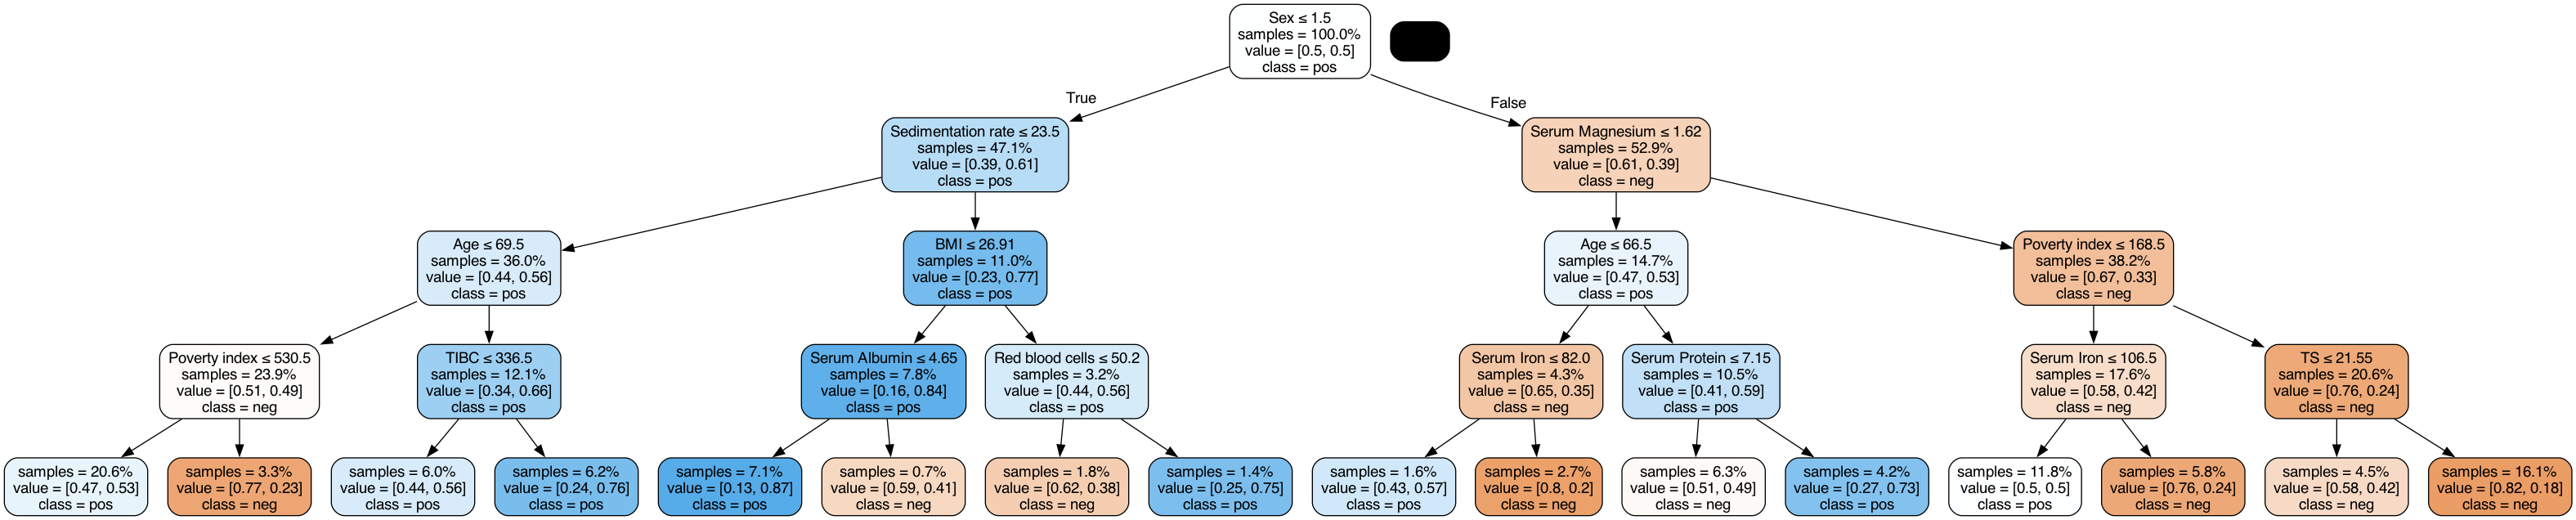

In [29]:
# Show the decision tree
Image(graph.create_png())

## 4. Random Forests

As before, we will use scikit-learn to build a random forest for the data. Let's include more values to the default hyperparameters.

In [30]:
models['Random Forest'] = {
        'model': RandomForestClassifier(class_weight=class_weights_dict_dropped, random_state=SEED),
        'params': {'n_estimators': [100, 120, 150], # Number of trees in the forest
                   'max_depth': [4, 10, 20, None],
                   'min_samples_leaf': [0.0005, 0.005, 0.05] # As a fraction of the total samples in the training set
                   }
}

In [31]:
# Select the second model only (i.e., Random Forest)
model_name, mp = list(models.items())[1]

# Run search
clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=custom_scorer)
# clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, scoring=custom_scorer)
clf.fit(X_train_dropped, y_train_dropped)

# Predict probabilities
rf = clf.best_estimator_

In [32]:
rf_ci_train, rf_ci_val, rf_ci_test = evaluate_classifier(
    my_clf = rf,
    Xtrain_=X_train_dropped,
    ytrain_=y_train_dropped.values,
    Xcv_=X_val_dropped,
    ycv_=y_val_dropped.values,
    Xtest_=X_test,
    ytest_=y_test.values,
    scorer=c_index_score
)

In [33]:
print(f"Train C-index: {rf_ci_train:.4f}")
print(f"Val C-index: {rf_ci_val:.4f}")
print(f"Test C-index: {rf_ci_test:.4f}")

Train C-index: 0.7639
Val C-index: 0.6539
Test C-index: 0.7129


In [34]:
# Store performance and fitted model
model_scores.append({
    'model': model_name,
    'CI_train': rf_ci_train,
    'CI_val': rf_ci_val,
    'CI_test': rf_ci_test
})

best_model_info[model_name]={
    'model': rf,
    'best_params': clf.best_params_,
    'CI_train': rf_ci_train,
    'CI_val': rf_ci_val,
    'CI_test': dt_ci_test
}

In [35]:
pd.DataFrame(model_scores)

,model,CI_train,CI_val,CI_test
0,Decision Tree,0.729156,0.636995,0.645626
1,Random Forest,0.763925,0.653908,0.712921


### Complete case analysis recap
The Random Forest model outperformed the Decision Tree model across all datasets. While a single decision tree captured some signal, its generalization was weaker, especially on unseen data. Random Forest offers a more robust ranking capability and is better suited for deployment in this context.

Let's explore various options to improve our classifier.

## 5. Imputation

By doing a complete case analysis, we threw away more than half of the data because of missing values for systolic blood pressure. Instead, we can try filling in, or imputing, these values.

First, let's explore to see if our data is missing at random or not. Let's plot histograms of the dropped rows against each of the covariates (aside from systolic blood pressure) to see if there is a trend. And let's compare these to the histograms of the feature in the entire dataset.

In [36]:
dropped_rows = X_train[X_train.isnull().any(axis=1)]

columns_except_Systolic_BP = [col for col in X_train.columns if col not in ['Systolic BP']]
len(columns_except_Systolic_BP)

17

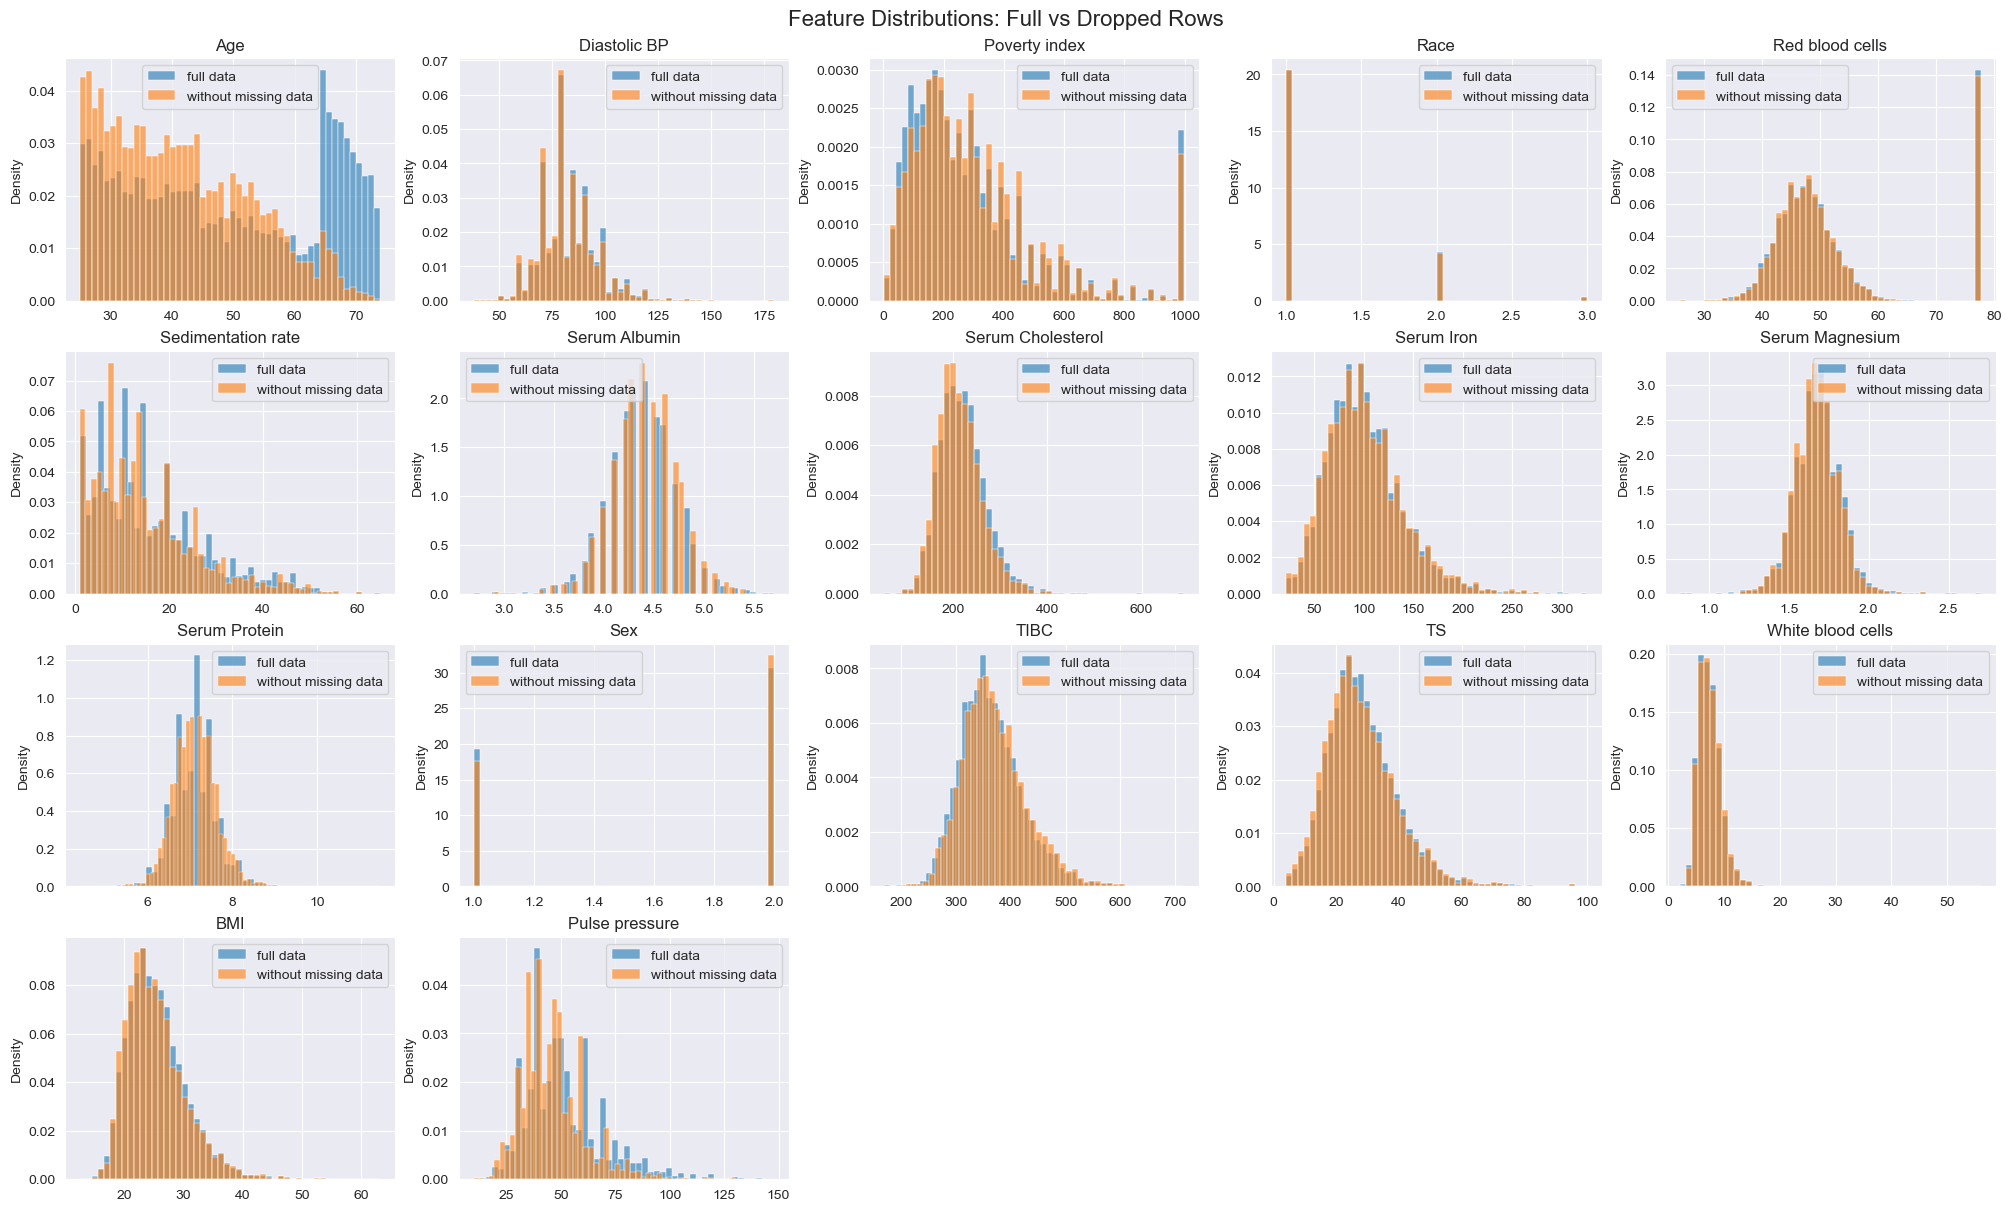

In [37]:
import math

# Grid layout
num_cols = 5
num_rows = math.ceil(len(columns_except_Systolic_BP) / num_cols)

fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 3), constrained_layout=True)
axes = axes.flatten()  # Flatten to 1D for easy indexing

for i, col in enumerate(columns_except_Systolic_BP):
    ax = axes[i]
    sns.histplot(X_train[col], stat="density", kde=False, bins=50, alpha=0.6, label='full data', ax=ax)
    sns.histplot(dropped_rows[col], stat="density", kde=False, bins=50, alpha=0.6, label='without missing data', ax=ax)

    ax.set_title(f"{col}")
    ax.set_xlabel("")
    ax.set_ylabel("Density")
    ax.legend()

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.suptitle("Feature Distributions: Full vs Dropped Rows", fontsize=16)
plt.show()

Most covariates show similar distributions whether or not rows with missing data are discarded. This suggests that missingness is largely independent of these variables.

If this independence held across all covariates, the data would be classified as **Missing Completely At Random (MCAR)**—meaning the likelihood of missingness is unrelated to any observed or unobserved data.

However, the age distribution tells a different story: patients over ~65 are disproportionately represented in rows with missing values.
One plausible explanation is that blood pressure measurements were skipped more often for older patients to reduce clinical burden.

Since missingness is related to an observed covariate (age), the data falls under **Missing At Random (MAR)**—where the probability of missingness depends on known variables.

Importantly, we have no evidence that the actual values of the missing systolic blood pressure readings depend on age. If they did—say, if older patients systematically had higher or lower unrecorded BP—then the data would be **Missing Not At Random (MNAR)**, where missingness depends on the unseen values themselves.

### 5.1 Error Analysis
Using the information from the plots above, let's try to find a subgroup of the test data on which the model performs poorly.

In [38]:
def bad_subset(forest, X_, y_, age_th=65):
    # define mask to select large subset with poor performance
    # currently mask defines the entire set
    mask = X_['Age'] > age_th

    X_subgroup = X_[mask]
    y_subgroup = y_[mask]
    subgroup_size = len(X_subgroup)

    y_subgroup_preds = forest.predict_proba(X_subgroup)[:, 1]
    performance = c_index_score(y_subgroup.values, y_subgroup_preds)
    
    return performance, subgroup_size

In [39]:
performance, subgroup_size = bad_subset(rf, X_test, y_test,65)
print(f"Subgroup size: {subgroup_size} \nSubgroup C-Index: {performance:.4f}")

Subgroup size: 439 
Subgroup C-Index: 0.6749


In [40]:
def find_bad_subset(forest, X_, y_, age_range=None):
    if age_range is None:
        age_range = np.arange(50, 75, 1)

    worst_cindex = float('inf')
    best_threshold = None
    best_size = 0

    for age_th in age_range:
        mask = X_['Age'] > age_th
        if mask.sum() < 30:  # Skip tiny subsets
            continue

        X_subgroup = X_[mask]
        y_subgroup = y_[mask]
        y_preds = forest.predict_proba(X_subgroup)[:, 1]

        ci = c_index_score(y_subgroup.values, y_preds)

        if ci < worst_cindex:
            worst_cindex = ci
            best_threshold = age_th
            best_size = len(X_subgroup)

    return {
        'worst_cindex': worst_cindex,
        'threshold': best_threshold,
        'subset_size': best_size
    }


In [41]:
findings = find_bad_subset(rf, X_test, y_test, age_range=np.arange(60, 75, 1))

In [42]:
pd.DataFrame(findings, index=[0])

,worst_cindex,threshold,subset_size
0,0.642489,69,205


### 5.2 Imputation Approaches
Seeing that our data is not missing completely at random, we can handle the missing values by replacing them with substituted values based on the other values that we have. This is known as imputation.

One type of imputation algorithm is univariate, which imputes values in the i-th feature dimension using only non-missing values in that feature dimension (e.g. SimpleImputer).

By contrast, multivariate imputation algorithms use the entire set of available feature dimensions to estimate the missing values (e.g. IterativeImputer).


#### 5.2.1 Univariate Feature Imputation

Let's try the **mean substitution**: replace the missing values for each feature with the mean of the available values.

In [43]:
# Impute values using the mean
imputer = SimpleImputer(strategy='mean')
imputer.fit(X_train)
X_train_mean_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_mean_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [44]:
models['RF with Univariate Imputation'] = {
        'model': RandomForestClassifier(class_weight=class_weights_dict_orig, random_state=SEED),
        'params': {'n_estimators': [100, 120, 150],
                   'max_depth': [4, 10, 20, None],
                   'min_samples_leaf': [0.0005, 0.005, 0.05, 0.1]
                   }
}

In [45]:
# Select the second model only
model_name, mp = list(models.items())[2]

# Run search
clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=custom_scorer)
# clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, scoring=custom_scorer)
clf.fit(X_train_mean_imputed , y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={False: np.float64(0.61),
                                                            True: np.float64(2.68)},
                                              random_state=10),
             param_grid={'max_depth': [4, 10, 20, None],
                         'min_samples_leaf': [0.0005, 0.005, 0.05, 0.1],
                         'n_estimators': [100, 120, 150]},
             scoring=make_scorer(c_index_score, response_method='predict'))

In [46]:
rf2_ci_train, rf2_ci_val, rf2_ci_test = evaluate_classifier(
    my_clf = clf.best_estimator_,
    Xtrain_=X_train_mean_imputed,
    ytrain_=y_train.values,
    Xcv_=X_val_mean_imputed,
    ycv_=y_val.values,
    Xtest_=X_test,
    ytest_=y_test.values,
    scorer=c_index_score
)

print(f"Train C-index: {rf2_ci_train:.4f}")
print(f"Val C-index: {rf2_ci_val:.4f}")
print(f"Test C-index: {rf2_ci_test:.4f}")

Train C-index: 0.8817
Val C-index: 0.7268
Test C-index: 0.7829


In [47]:
# Store performance and fitted model
model_scores.append({
    'model': model_name,
    'CI_train': rf2_ci_train,
    'CI_val': rf2_ci_val,
    'CI_test': rf2_ci_test
})

best_model_info[model_name]={
    'model':  clf.best_estimator_,  # Fitted with best parameters
    'best_params': clf.best_params_,
    'CI_train': rf2_ci_train,
    'CI_val': rf2_ci_val,
    'CI_test': rf2_ci_test
}

In [48]:
pd.DataFrame(model_scores)

,model,CI_train,CI_val,CI_test
0,Decision Tree,0.729156,0.636995,0.645626
1,Random Forest,0.763925,0.653908,0.712921
2,RF with Univariate Imputation,0.881702,0.726751,0.782889


In [49]:
best_model_info['RF with Univariate Imputation']['best_params']

{'max_depth': 20, 'min_samples_leaf': 0.005, 'n_estimators': 150}

Some big improvements. The model is complex enough to learn from the data, but simple enough to generalize well. We can improve the variance by fine-tuning hyperparameters.

#### 5.2.2 Multivariate Feature Imputation


In [50]:
# Impute using regression on other covariates
imputer = IterativeImputer(max_iter=10, min_value=0, random_state=SEED)
imputer.fit(X_train)
X_train_imputed = pd.DataFrame(imputer.transform(X_train), columns=X_train.columns)
X_val_imputed = pd.DataFrame(imputer.transform(X_val), columns=X_val.columns)

In [51]:
models['RF with Multivariate Imputation'] = {
        'model': RandomForestClassifier(class_weight=class_weights_dict_orig, random_state=SEED),
        'params': {'n_estimators': [100, 110, 120, 150],
                   'max_depth': [4, 10, 15, 20, None],
                   'min_samples_leaf': [0.0005, 0.005, 0.05, 0.01]
                   }
}

In [52]:
model_name, mp = list(models.items())[3]

# Run search
clf = GridSearchCV(mp['model'], mp['params'], cv=5, scoring=custom_scorer)
# clf = RandomizedSearchCV(mp['model'], mp['params'], cv=5, scoring=custom_scorer)
clf.fit(X_train_imputed, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={False: np.float64(0.61),
                                                            True: np.float64(2.68)},
                                              random_state=10),
             param_grid={'max_depth': [4, 10, 15, 20, None],
                         'min_samples_leaf': [0.0005, 0.005, 0.05, 0.01],
                         'n_estimators': [100, 110, 120, 150]},
             scoring=make_scorer(c_index_score, response_method='predict'))

In [53]:
rf3_ci_train, rf3_ci_val, rf3_ci_test = evaluate_classifier(
    my_clf = clf.best_estimator_,
    Xtrain_=X_train_imputed,
    ytrain_=y_train.values,
    Xcv_=X_val_imputed,
    ycv_=y_val.values,
    Xtest_=X_test,
    ytest_=y_test.values,
    scorer=c_index_score
)

print(f"Train C-index: {rf3_ci_train:.4f}")
print(f"Val C-index: {rf3_ci_val:.4f}")
print(f"Test C-index: {rf3_ci_test:.4f}")

Train C-index: 0.7943
Val C-index: 0.7225
Test C-index: 0.7729


In [54]:
# Store performance and fitted model
model_scores.append({
    'model': model_name,
    'CI_train': rf3_ci_train,
    'CI_val': rf3_ci_val,
    'CI_test': rf3_ci_test
})

best_model_info[model_name]={
    'model':  clf.best_estimator_,  # Fitted with best parameters
    'best_params': clf.best_params_,
    'CI_train': rf3_ci_train,
    'CI_val': rf3_ci_val,
    'CI_test': rf3_ci_test
}

## 6. Comparing Model Performances


In [55]:
pd.DataFrame(model_scores)

,model,CI_train,CI_val,CI_test
0,Decision Tree,0.729156,0.636995,0.645626
1,Random Forest,0.763925,0.653908,0.712921
2,RF with Univariate Imputation,0.881702,0.726751,0.782889
3,RF with Multivariate Imputation,0.794318,0.722493,0.772877


Note: With iterative imputation, we're able to reduce overfitting while maintaining generalization. This model is better suited for deployment.

Let's discuss explanations using SHAP.

<a name='7'></a>
## 7. Explanations: SHAP

Using a random forest has improved results, but we've lost some of the natural interpretability of trees. This section tries to explain the predictions using slightly more sophisticated techniques.

Let's apply **SHAP (SHapley Additive exPlanations)**, a cutting edge method to explain predictions made by black-box machine learning models (i.e., models which are too complex to be understandable by humans as is).

SHAP values explain the prediction by quantifying the additive importance of each feature to the prediction. Although it is computationally expensive to compute SHAP values for general black-box models, in the case of trees and forests there exists a fast polynomial-time algorithm. For more details, see the [TreeShap paper](https://arxiv.org/pdf/1802.03888.pdf).

Let's use the [shap library](https://shap.readthedocs.io/en/latest/) to do this for our random forest model.

In [56]:
rf_imputed = best_model_info['RF with Multivariate Imputation']['model']
X_test_risk = X_test.copy(deep=True)
X_test_risk.loc[:, 'risk'] = rf_imputed.predict_proba(X_test_risk)[:, 1]
X_test_risk = X_test_risk.sort_values(by='risk', ascending=False)
X_test_risk.head()

,Age,Diastolic BP,Poverty index,Race,Red blood cells,Sedimentation rate,Serum Albumin,Serum Cholesterol,Serum Iron,Serum Magnesium,Serum Protein,Sex,Systolic BP,TIBC,TS,White blood cells,BMI,Pulse pressure,risk
5493,67.0,80.0,30.0,1.0,77.7,59.0,3.4,231.0,36.0,1.40,6.3,1.0,170.0,202.0,17.8,8.4,17.029470,90.0,0.815692
864,74.0,110.0,105.0,1.0,46.9,45.0,4.4,233.0,102.0,1.70,7.3,1.0,180.0,283.0,36.0,9.2,26.906341,70.0,0.802323
2608,71.0,80.0,104.0,1.0,43.8,23.0,4.0,201.0,119.0,1.60,7.0,1.0,166.0,311.0,38.3,6.3,17.760766,86.0,0.787218
1390,69.0,78.0,48.0,1.0,42.7,47.0,3.8,185.0,78.0,1.90,7.6,1.0,142.0,345.0,22.6,5.9,21.975701,64.0,0.784993
1849,70.0,90.0,71.0,2.0,49.1,30.0,4.5,247.0,105.0,1.79,8.1,1.0,180.0,443.0,23.7,5.6,27.545809,90.0,0.783151


SHAP offers powerful visual tools to interpret machine learning predictions. These plots reveal which features matter most and how they drive individual or overall model decisions. Here's a quick overview of key SHAP visualizations:
* Waterfall Plot: Breaks down a prediction into additive feature contributions for one instance.
* Force Plot: Shows how each feature pushes a single prediction above or below the baseline.
* Summary Plot: Combines feature importance and impact across the dataset.
* Dependence Plot: Highlights how a feature’s value affects its SHAP value, often revealing interactions.
* Decision Plot: Visualizes the cumulative effect of features on model output across samples.

Each plot turns black-box models into transparent decision-makers. This is ideal for diagnostics, fairness checks, and storytelling.

### Waterfall Plot
A good way to find out feature contributions for one instance

In [57]:
# Creates a SHAP explainer for the trained model.
# This explainer object helps to decompose predictions into feature contributions.
explainer = shap.TreeExplainer(rf_imputed)

In [58]:
# Function to compute SHAP values for a single entry or the dataset to explain predictions.
def shap_waterfall_plot(patient_data, shap_explainer, class_idx, feature_list):
    """
    Generate a SHAP waterfall plot for a single patient instance.
    Display a SHAP waterfall plot showing how each feature contributed to the prediction.

    Args:
        patient_data: pandas.Series
            A single patient's feature vector (shape: [num_features,]).
            Should be extracted using `.iloc[index]` from a DataFrame.

        shap_explainer: shap.Explainer or shap.TreeExplainer
            A fitted SHAP explainer object compatible with the model used.

        class_idx: int
            Index of the class to explain (e.g., 1 for positive class in binary classification).

        feature_list : list of str
            List of feature names corresponding to the patient's data.

    """

    Xp = patient_data # shape: (num_features,)

    # Compute SHAP values for the selected class
    shap_vals = shap_explainer.shap_values(Xp)[:, class_idx] # shape: (num_features,)

    # Generate the waterfall plot
    shap.waterfall_plot(
        shap.Explanation(
            values=shap_vals,
            base_values=shap_explainer.expected_value[class_idx],
            data= Xp,
            feature_names=feature_list
        )
    )

In [59]:
# Select patient of interest
patient0_id = X_test_risk.index[0] # Patient with the highest risk

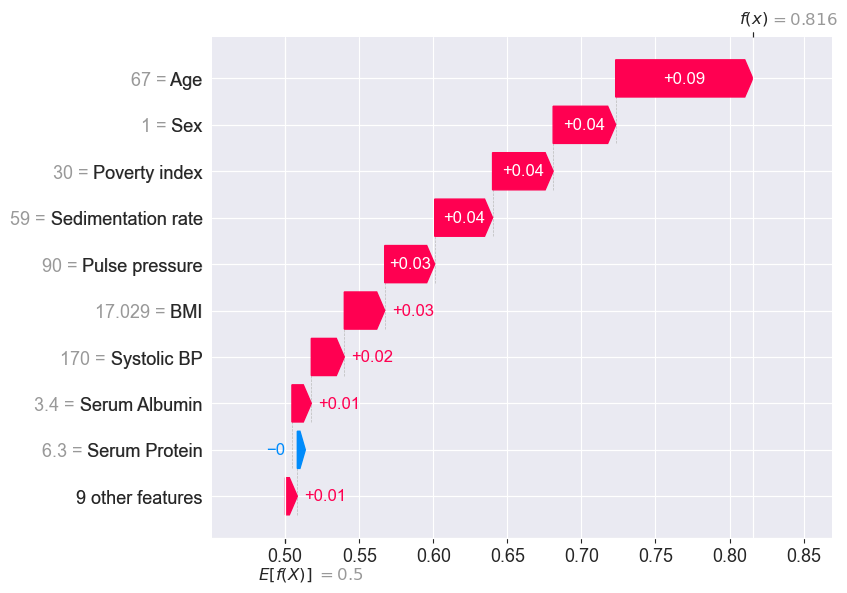

In [60]:
# Check
X_patient = X_test.loc[patient0_id,:]
shap_waterfall_plot(patient_data=X_patient,
                    shap_explainer=explainer,
                    class_idx=1, # 1 for positive class
                    feature_list=X_train.columns.tolist()
                   )

### Force Plot
Shows how each feature pushes a single prediction above or below the baseline.

In [61]:
def shap_force_plot(patient_data, shap_explainer, class_idx, feature_list):
    """
    Generate a SHAP force plot for a single patient instance.

    Args:
        patient_data: pandas.Series
            A single patient's feature vector (shape: [num_features,]).
            Should be extracted using `.iloc[index]` from a DataFrame.

        shap_explainer: shap.Explainer or shap.TreeExplainer
            A fitted SHAP explainer object compatible with the model used.

        class_idx: int
            Index of the class to explain (e.g., 1 for positive class in binary classification).

        feature_list : list of str
            List of feature names corresponding to the patient's data.

    """

    Xp = patient_data # shape: (num_features,)

    # Compute SHAP values for the selected class
    shap_vals = shap_explainer.shap_values(Xp)[:, class_idx] # shape: (num_features,)

    # Generate the waterfall plot
    shap.force_plot(
        base_value=shap_explainer.expected_value[class_idx],
        shap_values=shap_vals,
        features= Xp,
        feature_names=feature_list,
        matplotlib=True
    )

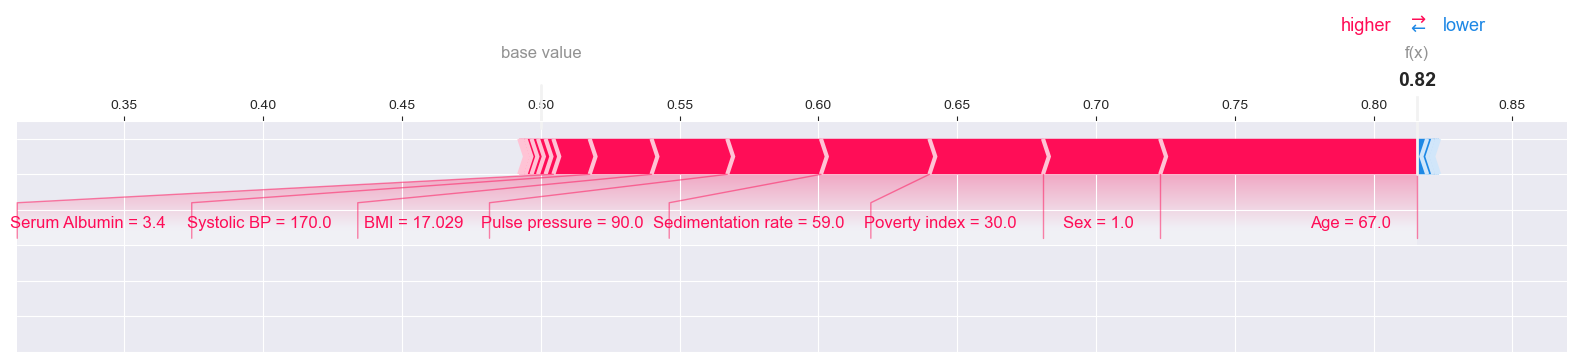

In [62]:
shap_force_plot(patient_data=X_patient.round(3),
                shap_explainer=explainer,
                class_idx=1, # 1 for positive class
                feature_list=X_train.columns.tolist()
                )

How to read this chart:
- The red sections on the left are features which push the model towards the final prediction in the positive direction (i.e. a higher Age increases the predicted risk).
- The blue sections on the right are features that push the model towards the final prediction in the negative direction (if an increase in a feature leads to a lower risk, it will be shown in blue).

## Summary Plot
One can also use SHAP values to understand the model output in aggregate.

This plot combines feature importance and impact across the dataset.

In [63]:
shap_values = explainer.shap_values(X_test)

SHAP’s summary plot is sensitive to how the crowd is lined up. Sorting by risk changes the choreography, even if the cast is unchanged.

This is like photographing the same crowd from two angles—same people, different story.

In [64]:
shap_values.shape

(1716, 18, 2)

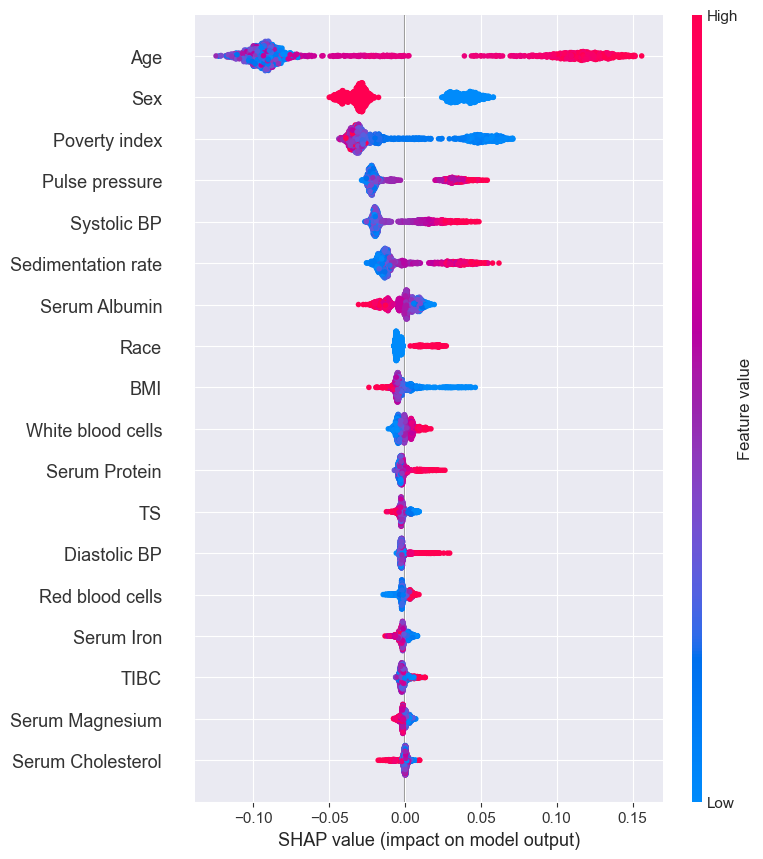

In [65]:
import warnings
warnings.simplefilter("ignore", category=FutureWarning)

shap.summary_plot(shap_values[:,:,1], X_test)

Clearly, being a woman (`sex = 2.0`, as opposed to men for which `sex = 1.0`) has a negative SHAP value, meaning that it reduces the risk of dying within 10 years. High age and high systolic blood pressure have positive SHAP values, and are therefore related to increased mortality.

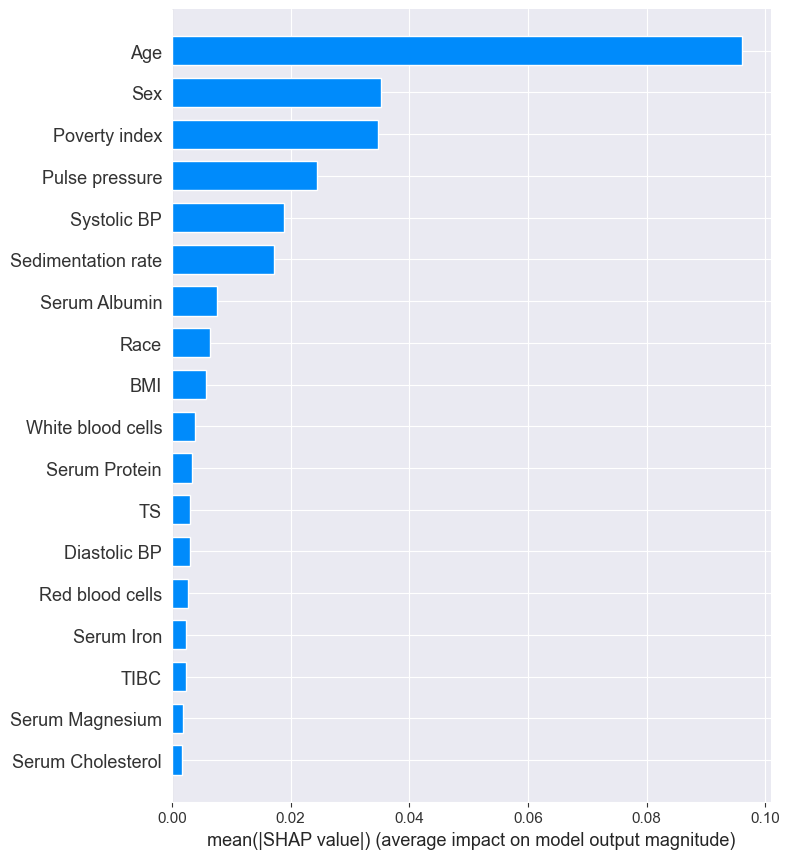

In [66]:
shap.summary_plot(shap_values[:,:,1], X_test, plot_type="bar")

This plot tells which features have the largest average impact on model predictions.
In our case, Age, Sex, and  Poverty are the top influencers.

### Dependence Plot
Dependence plots show how a feature's SHAP value varies across data points, with color indicating another feature's value—revealing potential interactions.

This highlights how feature values influence their impact on predictions and often reveals interactions between features.

In [67]:
X_test.columns

Index(['Age', 'Diastolic BP', 'Poverty index', 'Race', 'Red blood cells',
       'Sedimentation rate', 'Serum Albumin', 'Serum Cholesterol',
       'Serum Iron', 'Serum Magnesium', 'Serum Protein', 'Sex', 'Systolic BP',
       'TIBC', 'TS', 'White blood cells', 'BMI', 'Pulse pressure'],
      dtype='object')

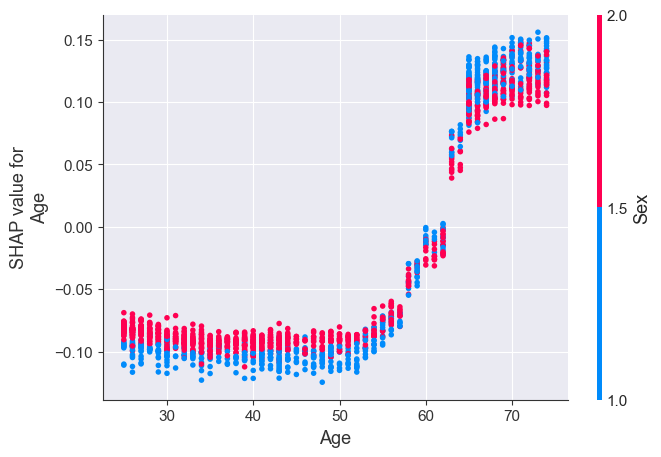

In [68]:
# Let's consider 'Age' and 'Sex'
shap.dependence_plot('Age', shap_values[:,:,1], X_test, interaction_index='Sex')

We see that while Age > ~62 is generally bad (positive SHAP value), being a woman generally reduces the impact of age. This makes sense since we know that women generally live longer than men.

Let's now look at poverty index and age.

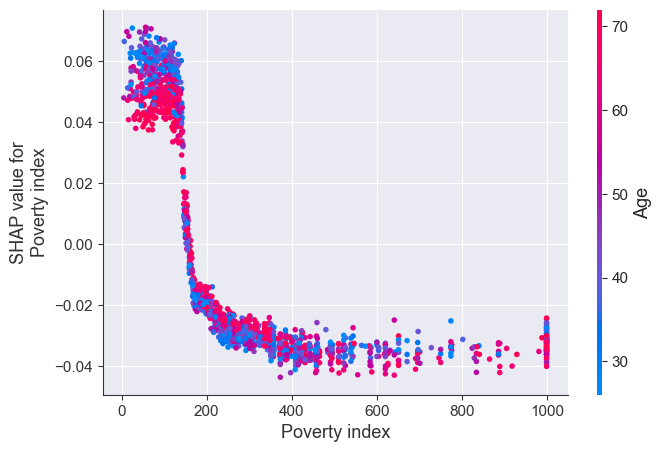

In [69]:
shap.dependence_plot('Poverty index', shap_values[:,:,1], X_test, interaction_index='Age')

The impact of poverty index drops off quickly, and for higher income individuals, age begins to explain much of variation in the impact of poverty index. Older individuals show stronger negative SHAP impact — high income might attenuate age-related vulnerabilities more visibly in model predictions.

One can try different pairs to uncover interesting relationships.